## Fine-tining a Vision Transformer Model With a Custom Biomedical Dataset

### Dataset Info
The Custome dataset is hand-made, containing 780 images with three classes:
* bengin
* malignant
* normal

### Model Info
The model we fine-tune will be Google’s "vit-large-patch16-224". It is trained on ImageNet-21k (14M images, 21.843 classes), and fine-tuned on ImageNet 2012 (1M images, 1.000 classes) at resolution 224x224.

#### Explanation about model:
https://huggingface.co/google/vit-large-patch16-224

## Install neccesary libraries

In [ ]:
!pip install datasets transformers accelerate torch scikit-learn matplotlib wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

## Dataset preparation


In [ ]:
from datasets import load_dataset

dataset = load_dataset("emre570/breastcancer-ultrasound-images")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/624 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/156 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

We got our dataset. But we don’t have a validation set. To create the validation set, we will calculate the size of the validation set as a fraction of the training set based on the size of the test set. Then we split the training dataset into new training and validation subsets.

In [ ]:
# Get the number of each set

# Number of samples in the test set
test_num = len(dataset["test"])

# Number of samples in the training set
train_num = len(dataset["train"])

#  This variable calculates the ratio of the number of test samples to the number of training samples.
# This ratio will be used to determine the size of the validation set when splitting the training data.
val_size = test_num / train_num

train_val_split = dataset["train"].train_test_split(test_size = val_size)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

* train_val_split:

This variable stores the result of splitting the training set into two subsets:

a new training set and a validation set. The train_test_split method is used here.

* test_size = val_size:

This parameter specifies that the size of the validation set should be the same ratio (val_size) as the ratio of the test set size to the original training set size. In other words, the validation set will have a similar proportion to the training set as the test set does.

* Result:


After running this code, train_val_split will contain two subsets:

* train_val_split['train']: The new training set, which is smaller than the original training set since a portion has been set aside for validation.

* train_val_split['test']: The validation set created from the original training set.

In [ ]:
from datasets import DatasetDict

dataset = DatasetDict(
    {"train": train_val_split["train"], "validation": train_val_split["test"], "test": dataset["test"]}

)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

* DatasetDict:

This is useful for organizing and managing different subsets of our data. When working with machine learning models, it's common to have separate sets of data for training, validation, and testing, and DatasetDict helps keep these subsets organized in a single object.

* Typical Workflow:

The training set is used to train the model.
The validation set is used to tune hyperparameters and avoid overfitting.

The test set is used for the final evaluation of the model's performance.

By structuring our dataset this way, we can easily pass the dataset object to various functions or models that require these subsets, ensuring consistency and clarity in our handling process.

## Assign subsets to different variables

In [ ]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

## See the image is a PIL. (Image with a label associated with it.)

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=549x465>,
 'label': 0}

## See the features of train set

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

## Show one image from each class from dataset

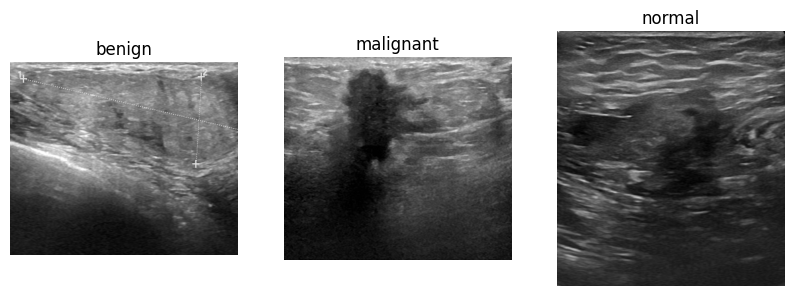

In [ ]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize = (10, 10))

# Loop trough the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
  label = train_ds.features["label"].names[sample["label"]]
  if label not in shown_labels:
    plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) +1)
    plt.imshow(sample["image"])
    plt.title(label)
    plt.axis("off")
    shown_labels.add(label)
    if len(shown_labels) == len(train_ds.features["label"].names):
      break

plt.show()

* Data Processing
The dataset is ready. But we are not ready for fine-tuning. We will follow this procedures respectively:

* Label Mapping:

We convert between label IDs and their corresponding names, useful for model training and evaluation.

* Image Processing:

Then, we utilize the ViTImageProcessor to standardize input image sizes and applies normalization specific to the pretrained model. Also, will define different transformations for training, validation, and testing to improve model generalization using torchvision.

* Transform Functions:

Implement functions to apply the transformations to the dataset, converting images to the required format and dimensions for the ViT model.

* Data Loading:

Set up a custom collate function to properly batch images and labels, and create a DataLoader for efficient loading and batching during model training.

* Batch Preparation:

Retrieve and display the shape of data in a sample batch to verify correct processing and readiness for model input.

## Label Mapping

In [ ]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}

label2id = {label: id for id, label in id2label.items()}

id2label, id2label[train_ds[0]["label"]]

({0: 'benign', 1: 'malignant', 2: 'normal'}, 'benign')

## Image processing

In [ ]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean = image_mean, std = image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

* CenterCrop:

Crops the center part of the image to a given size.

* Compose:
Composes several transformations together to apply them sequentially.

*Normalize:

Normalizes a tensor image with mean and standard deviation.

*RandomHorizontalFlip:
Randomly flips the image horizontally.

* RandomResizedCrop:

Randomly crops the image to a target size, resizing it first to ensure the crop is possible.

* ToTensor:
Converts a PIL Image or NumPy array to a PyTorch tensor.

* Resize:
Resizes the image to a given size.

* normalize:

This is the transformation that normalizes the image tensor by subtracting the mean and dividing by the standard deviation for each channel.

* RandomHorizontalFlip():
Randomly flips the image horizontally with a probability of 0.5.

## Create transform functions

In [ ]:
def apply_train_transforms(examples):
  examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
  return examples

def apply_val_transforms(examples):
  examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
  return examples

def apply_test_transforms(examples):
  examples["pixel_values"] = [test_transforms(image.convert("RGB")) for image in examples["image"]]
  return examples

* apply_train_transforms

* Purpose:

These functions are designed to apply the training transformations to each image in the input batch.

* Process:

It converts each image to RGB mode using image.convert("RGB"), ensuring that the image has three color channels.

* train_transforms:

It applies the train_transforms to each image, which includes random cropping, flipping, tensor conversion, and normalization.

* val_transforms:

It applies the val_transforms, which include resizing, center cropping, tensor conversion, and normalization.

* test_transforms:

It applies the val_transforms pipeline to each image, ensuring consistent preprocessing between validation and testing.

The transformed images are stored in the "pixel_values" field of the examples dictionary.

Output:

The function returns the updated examples dictionary, where "pixel_values" contains the transformed images.

## Apply transform functions to each set

In [ ]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [ ]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=549x465>,
 'label': 0,
 'pixel_values': tensor([[[ 0.6235,  0.6000,  0.5216,  ...,  0.4745,  0.4824,  0.5216],
          [ 0.5922,  0.5922,  0.5216,  ...,  0.2235,  0.2078,  0.1922],
          [ 0.3804,  0.4431,  0.4431,  ...,  0.0745,  0.0510,  0.0902],
          ...,
          [-0.7804, -0.7882, -0.7725,  ..., -0.8275, -0.8118, -0.7882],
          [-0.7961, -0.7961, -0.7725,  ..., -0.8118, -0.8118, -0.8118],
          [-0.8196, -0.8275, -0.8118,  ..., -0.8353, -0.8275, -0.8196]],
 
         [[ 0.6235,  0.6000,  0.5216,  ...,  0.4745,  0.4824,  0.5216],
          [ 0.5922,  0.5922,  0.5216,  ...,  0.2235,  0.2078,  0.1922],
          [ 0.3804,  0.4431,  0.4431,  ...,  0.0745,  0.0510,  0.0902],
          ...,
          [-0.7804, -0.7882, -0.7725,  ..., -0.8275, -0.8118, -0.7882],
          [-0.7961, -0.7961, -0.7725,  ..., -0.8118, -0.8118, -0.8118],
          [-0.8196, -0.8275, -0.8118,  ..., -0.8353, -0.8275, -0.8196]],


## Data Loading

In [ ]:
import torch
from torch.utils.data import DataLoader

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])
  return {"pixel_values": pixel_values, "labels": labels}

train_dl = DataLoader(train_ds, collate_fn = collate_fn, batch_size = 4)

## Batch Preparation

In [ ]:
batch = next(iter(train_dl))
for k, v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Fine-tuning the Model

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name, id2label = id2label, label2id = label2id, ignore_mismatched_sizes = True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* model_name = "google/vit-base-patch16-224":

This is the identifier for the ViT model variant you want to use, pre-trained on ImageNet with images resized to 224x224 pixels.

* id2label and label2id:

These mappings are essential for converting between the model's output (logits) and the actual class labels in our dataset. During fine-tuning and evaluation, this ensures the model's predictions are interpreted correctly.

* ignore_mismatched_sizes=True:

If our dataset has a different number of classes than the model was originally trained on, this flag helps to adjust the model's output layer size accordingly. This avoids errors related to shape mismatches in the model's final classification head.

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir = "output_models",
    save_total_limit = 2,
    report_to = "wandb",
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 10,
    per_device_eval_batch_size = 4,
    num_train_epochs = 40,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    logging_dir = "logs",
    remove_unused_columns = False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Explanation of TrainingArguments

* output_dir = "output_models":

Specifies the directory where the model checkpoints and other outputs will be saved during training.

* save_total_limit = 2:

Limits the number of saved checkpoints to 2. Older checkpoints are deleted to save space.

* report_to = "wandb":

Specifies where to log metrics. Here, it's set to report to Weights & Biases (wandb), a popular tool for experiment tracking. Make sure to set up our wandb account and log in before training if you use this option.

* save_strategy = "epoch":

Saves the model checkpoint at the end of every epoch.

* evaluation_strategy = "epoch":

Evaluates the model at the end of each epoch. This is useful for monitoring validation performance during training.

* learning_rate = 2e-5:

Sets the learning rate for the optimizer. This is a typical value for fine-tuning transformers models.

* pre_device_train_batch_size = 10:

Sets the batch size per device (e.g., per GPU) during training. If using multiple GPUs, the effective batch size will be pre_device_train_batch_size multiplied by the number of GPUs.

* pre_device_eval_batch_size = 4:

Sets the batch size per device during evaluation.

* num_train_epochs = 40:

Specifies the number of training epochs. The model will go through the entire training dataset 40 times.

* weight_decay = 0.01:

Applies weight decay (a form of regularization) to the optimizer to prevent overfitting.

* load_best_model_at_end = True:

Loads the best model (based on evaluation metrics) at the end of training. This is useful for ensuring the final model is the best one encountered during training.
our
* logging_dir = "logs":

Specifies the directory where logs will be saved. This includes logs for training loss, evaluation metrics, and more.

* remove_unused_columns = False:

If set to True, this option would remove columns that are not needed by the model (e.g., additional features in the dataset). Here, it is set to False, meaning all columns are kept.

## Begine fine-tunung process with Trainer

In [ ]:
trainer = Trainer (
    model,
    train_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    data_collator = collate_fn,
    tokenizer = processor,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.613181
2,No log,0.391603
3,No log,0.427389
4,No log,0.374563
5,No log,0.344862
6,No log,0.338552
7,No log,0.506179
8,No log,0.360826
9,No log,0.402993
10,No log,0.354656


TrainOutput(global_step=1880, training_loss=0.2664892744510732, metrics={'train_runtime': 4691.6336, 'train_samples_per_second': 3.99, 'train_steps_per_second': 0.401, 'total_flos': 5.128065177052447e+18, 'train_loss': 0.2664892744510732, 'epoch': 40.0})

## Evaluating the model to test set

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.36451223492622375, 'test_runtime': 7.843, 'test_samples_per_second': 19.89, 'test_steps_per_second': 4.973}


### See how our model predicted the classes using scikit-learn’s Confusion Matrix Display and show Recall Score.

## Draw model's Confusion Matrix

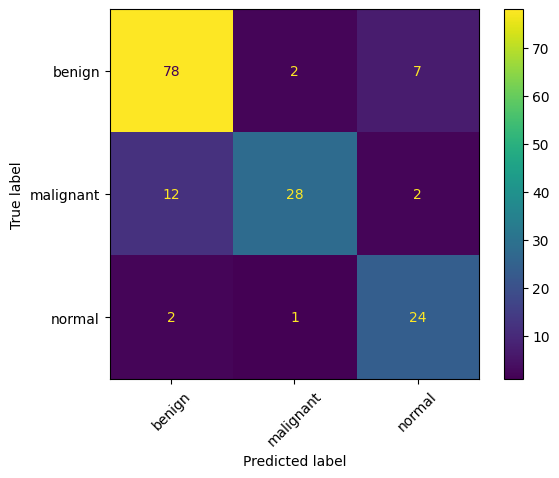

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(xticks_rotation = 45)

## Recall Score

In [ ]:
from sklearn.metrics import recall_score

# Calculate the recall scores
# 'None' calculates recall for each class separately

recall = recall_score(y_true, y_pred, average = None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

Recall for benign: 0.90
Recall for malignant: 0.67
Recall for normal: 0.89
